# Retinal Disease Classification

In this project the problem of multi disease classification is tackled. Particularly, the focus of this project is on a subset of diseases presented on this Kaggle competition https://www.kaggle.com/c/vietai-advance-course-retinal-disease-detection/overview.

We have images from Retinas that can have multiple diseases:
* Normal
* Diabetic Retinopathy
* Glaucoma

The objective of this project is to classify an image of a retina with the labels above

# Bibliography

Using LIME as an explanatory tool for image classification:
* https://towardsdatascience.com/interpreting-image-classification-model-with-lime-1e7064a2f2e5
* https://lime-ml.readthedocs.io/en/latest/lime.html

For the semi-supervised learning task:
* https://machinelearningmastery.com/semi-supervised-learning-with-label-spreading/

# Task 0: Loading data + libraries + EDA

In [ ]:
# Libraries
# -------------------------------------------------
import numpy as np
import gc
import os
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import load_img
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage.segmentation import mark_boundaries
from sklearn.semi_supervised import LabelSpreading
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from tabulate import tabulate
import matplotlib.image as mpimg

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# Put your folder here os.chdir()

Mounted at /content/drive


In [ ]:
# Constants
# -------------------------------------------------
FOLDER_IMAGES_TRAIN = "Data/train/train/"
FOLDER_IMAGES_AUGME = "Data/train/aug/"
FOLDER_XY_TRAIN = "Data/train/"
FOLDER_IMAGES_TEST = "Data/test/test/"
FOLDER_X_TEST = "Data/test/"
MODELS_FOLDER = "Models/"
METADATA_PATH = FOLDER_XY_TRAIN + "train.csv"
CLASSES = 4
CLASSES_NAMES = [
                "normal",                       # 0
                "diabetic retinopathy",         # 1
                "glaucoma",                     # 2
                "dr + glaucoma"                 # 3
                ]
ORIGINAL_CLASSES_NAMES = [
                 "opacity",                     # 0
                 "diabetic retinopathy",        # 1
                 "glaucoma",                    # 2
                 "macular edema",               # 3
                 "macular degeneration",        # 4
                 "retinal vascular occlusion",  # 5
                 "normal"]                      # 6

In [ ]:
def load_metadata_dictionary(metadata_path = METADATA_PATH):
    """
    Loads the metadata of the training examples and creates a dictionary
    Treats the problem as a single-label, that is, every combination available
    is treated as a label.

    Arguments:
        metadata_path: the path of the file
        
    Returns:
        class_by_file: file_name -> label
    """
    
    # Load the metadata of the files
    df = pd.read_csv(metadata_path)

    # Drop non relevant classes
    columns_to_drop = ["opacity","macular edema","macular degeneration","retinal vascular occlusion"]
    df.drop(columns_to_drop, axis = 1, inplace=True)

    # Reorder of the columns
    df = df[["filename","normal","diabetic retinopathy","glaucoma"]]

    # Just consider images where at least 1 of this classes is present
    df = df[df["normal"] + df["diabetic retinopathy"] + df["glaucoma"] >0]

    # Initialize dictionary
    class_by_file = {}
    
    # Fill the dict
    counts_per_label = [0]*4
    for index, row in df.iterrows():
        filename = row[0]
        is_normal = row[1]
        is_diabrt = row[2]
        is_glauco = row[3]
        label = None

        if is_normal == 1 and is_diabrt == 0 and is_glauco == 0: # Class 0
            label = 0
        elif is_normal == 0 and is_diabrt == 1 and is_glauco == 0: # Class 1
            label = 1
        elif is_normal == 0 and is_diabrt == 0 and is_glauco == 1: # Class 2
            label = 2
        elif is_normal == 0 and is_diabrt == 1 and is_glauco == 1: # Class 3
            label = 3
        
        if label is None:
            raise ValueError("Did not find a class for row: " + str(row))
        else:
            class_by_file[filename] = label
            counts_per_label[label] = counts_per_label[label] + 1
    
    print(f"The counts per label is {counts_per_label}")
    return class_by_file

In [ ]:
def load_images_and_save_dataset(height: int, width: int, channels: int, input_folder = FOLDER_IMAGES_TRAIN, output_folder = FOLDER_XY_TRAIN, number_classes :int = CLASSES):
    """
    Creates X and y array from the traininig data set and reshapes it to the desired resolution.
    Then saves these arrays with names:
    Name for X: X_h_x_w_x_c.npy
    Name for y: y_single_label.npy
    input_folder: folder to read the images
    output_folder: folder to save the arrays
    X shape -> (m, h, w, c)
    y shape -> (m, ) 

    Arguments:
        height (int): image height dimension
        width (int): image width dimension
        channels (int): image channel dimension
        number_classes (int): number of classes
    
    Returns:
        None
    """
    
    # Load the metadata and the label per image
    # filename -> [y1,y2,y3]
    # Example:
    # asdasdas.jpg -> [0,1,1]
    metadata = load_metadata_dictionary()    

    # Count the number of files
    m = len(metadata)
    print(f"there are {m} interesting files in {FOLDER_IMAGES_TRAIN}")

    # Now initialize the X and y array
    print(f"Initialiazing X to shape {(m, height, width, channels)} and y array to shape {(m,)}")
    X = np.zeros((m, height, width, channels))
    y = np.zeros((m,))

    # Now read the images and put the info onto X and y
    for j, file_name in enumerate(metadata.keys()):

        if j % 100 == 0:
            print(f"Reading image {j+1} / {m}")

        label = metadata[file_name]

        # Filling y
        y[j] = label

        # Filling X    
        path = input_folder + file_name
        image_resized = load_img(path, target_size = (height, width))
        x_image_array = np.reshape(image_resized, (1, height, width, channels))
        X[j] = x_image_array
    
    # Saving the dataset now
    X_name = output_folder + "X_" + str(height) + "_x_" + str(width) + "_x_" + str(channels) + ".npy"
    y_name = output_folder + "y_single_label.npy"
    np.save(X_name, X)
    np.save(y_name, y)
    print(f"Saved X as {X_name}")
    print(f"Saved y as {y_name}")

In [ ]:
# Run this cell to create a new dataset and save the X,y arrays on google drive
load_images_and_save_dataset(151,151,3)

The counts per label is [525, 736, 578, 19]
there are 1858 interesting files in Data/train/train/
Initialiazing X to shape (1858, 151, 151, 3) and y array to shape (1858,)
Reading image 1 / 1858
Reading image 101 / 1858
Reading image 201 / 1858
Reading image 301 / 1858
Reading image 401 / 1858
Reading image 501 / 1858
Reading image 601 / 1858
Reading image 701 / 1858
Reading image 801 / 1858
Reading image 901 / 1858
Reading image 1001 / 1858
Reading image 1101 / 1858
Reading image 1201 / 1858
Reading image 1301 / 1858
Reading image 1401 / 1858
Reading image 1501 / 1858
Reading image 1601 / 1858
Reading image 1701 / 1858
Reading image 1801 / 1858
Saved X as Data/train/X_single_label_151_x_151_x_3.npy
Saved y as Data/train/y_single_label.npy


In [ ]:
def load_dataset(height: int, width: int, channels: int, dataset_folder = FOLDER_XY_TRAIN, single_label = True):
    """
    Loads a dataset with dimensions h x w

    Arguments:
        height (int): image height dimension
        width (int): image width dimension 
        dataset_folder: folder to search for the X and y arrays
        single_label: True or False       
    
    Returns:
        X (ndarray): of shape (m, h, w, 3)
        y (ndarray): of shape (m, ) if single_label = True
    """

    X_path = dataset_folder + "X_" + str(height) + "_x_" + str(width) + "_x_" + str(channels) + ".npy"
    X = np.load(X_path)
    print(f"X has shape {X.shape}")

    y_path = ""
    if single_label:        
        y_path = dataset_folder + "y_single_label.npy"
    else:
        y_path = dataset_folder + "y_multi_label.npy"

    y = np.load(y_path)
    print(f"y has shape {y.shape}")

    return X, y

In [ ]:
def normalize(X: np.array):
    """
    Normalize the X dataset by dividing by 255
    TODO: check that all the values are lesser than 255

    Arguments:
    X (np.array): the unnormalized array

    Returns
    Xn (np.array): the normalized array
    """
    
    Xn = X / 255.0

    min_value = np.amin(Xn)
    max_value = np.amax(Xn)

    assert min_value >= 0, "normalized min value is not >= 0"
    assert max_value <= 1, "normalized max value is not <= 1"

    return Xn

In [ ]:
# Run this cell to load the dataset already saved on google drive
X, y = load_dataset(151,151,3)
X = normalize(X)

X has shape (1858, 151, 151, 3)
y has shape (1858,)


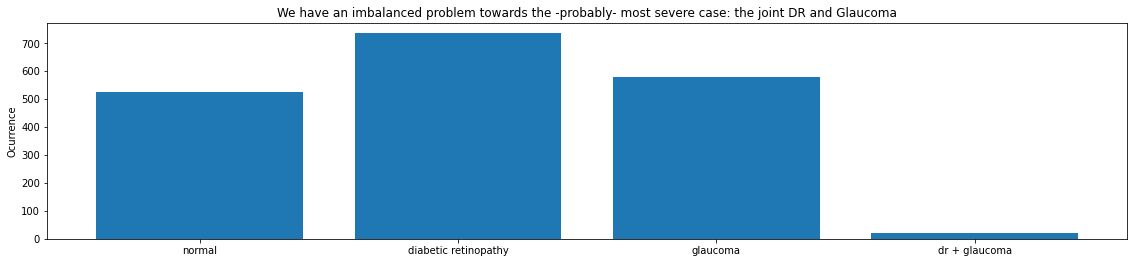

In [ ]:
# Now let's check the distribution of the classes
unique, counts = np.unique(y, return_counts=True)

# Plot
plt.rcParams["figure.figsize"] = (15,3)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_ylabel("Ocurrence")
ax.set_title("We have an imbalanced problem towards the -probably- most severe case: the joint DR and Glaucoma")
ax.bar(CLASSES_NAMES, counts)
plt.show()

# Task 1: Modelling and training

## 1.1 Auxiliar functions

In [ ]:
def one_hot_encode(y, k = CLASSES):
    """
    Creates the one hot encoding version of the y vector

    Arguments:
        y: vector of shape (m,)
    Returns
        ohe: vector of shape (m,k)
    """
    m = y.shape[0]
    assert y.shape == (m,), "Wrong shape of y"
    return tf.one_hot(y, k)

In [ ]:
# This class encapsulates useful functions for saving and retrieving the training history and the models
class Model:
    
    metrics_column_names = ["epoch", 'loss', 'recall', 'val_loss', 'val_recall']

    def __init__(self, id:str, keras_model = None, model_folder = MODELS_FOLDER):
        self.id = id
        self.keras_model = keras_model
        self.history_path = model_folder + "m" + self.id + ".csv"
        self.model_path = model_folder + "m" + self.id + ".h5"
        callback_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                                                    self.model_path, 
                                                    monitor ="val_recall", 
                                                    verbose = 1, 
                                                    save_best_only = True,
                                                    mode = "max"
                                                    )
        callback_reduce_LR_onPlateau = tf.keras.callbacks.ReduceLROnPlateau(
                                                    monitor = "val_loss", 
                                                    verbose = 1,
                                                    factor = 0.5,
                                                    patience = 9999999,
                                                    mode = "min"
                                                    )
        callback_early_stopping = tf.keras.callbacks.EarlyStopping(
                                                    monitor = "val_loss", 
                                                    patience = 999999,
                                                    verbose = 1,
                                                    mode = "min"
                                                    )
        self.callbacks = [callback_checkpoint, callback_reduce_LR_onPlateau, callback_early_stopping]
    

    def load_history(self):
        """
        Loads the .csv history file and the last epoch of training

        Arguments:
            None
        
        Returns:
            history (pd.DataFrame)
            last_epoch (int)
        """
        df = None
        last_epoch = -1
        if os.path.isfile(self.history_path):
            df = pd.read_csv(self.history_path)[Model.metrics_column_names]
            last_epoch = df["epoch"].max()
            print(f"Last training history read, last epoch was #{last_epoch}")
        else:
            print("Last training history not found, starting now from epoch #1")
        
        return df, last_epoch


    def load_model(self):
        """
        Loads the .h5 model file

        Arguments:
            None
        
        Returns:
            None
        """
        if os.path.isfile(self.model_path):
            self.keras_model = keras.models.load_model(self.model_path, compile = True)
            self.keras_model.compile (loss = self.keras_model.loss, 
                                      optimizer = self.keras_model.optimizer, 
                                      metrics = keras.metrics.Recall(name="recall"))
            print(f"Successfully loaded model {self.model_path}")
        else:
            print("Previous saved model not found")


    def plot_learning_curves(self, title_ = None):
        """
        Plots the training and validation loss curves over epochs from the saved history .csv file

        Arguments:
            title_: optional
        
        Returns:
            None
        """
        df, last_epoch = self.load_history()        
        if df is not None:
            print(df.columns)
            plt.plot(df['loss'])
            plt.plot(df['val_loss'])

            my_title = title_
            if my_title is None:
                my_title = "Model #" + self.id + " loss per epoch"

            plt.title(my_title)
            plt.ylabel('Loss')
            plt.xlabel('Epoch')
            plt.legend(['Train', 'Test'], loc='upper right')
            plt.show()
        else:
            print("no history file found")


    def retrieve_metrics(self, history):
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        recall = history.history['recall']
        val_recall = history.history['val_recall']
        return loss, val_loss, recall, val_recall


    def train_with_augmentation(self, train_generator, X_test, y_test, epochs = 10):
        """
        Trains the model with a generator the train set

        Arguments:
            train_generator: generator
            X_test:
            y_test:
            epochs:
        
        Returns:
            None
        """

        # Look if the model already exist and load it
        self.load_model()
        
        # Load previous history
        old_df, last_epoch = self.load_history()
        
        # Now train
        if self.keras_model is not None:
            history_new = self.keras_model.fit(x = train_generator, 
                                               epochs = epochs, 
                                               verbose = 1, 
                                               steps_per_epoch = 1, 
                                               validation_data = (X_test, y_test),
                                               callbacks = self.callbacks                                               
                                               )
            
            # Retrieve metrics
            print("\ntraining finished!")
            loss, val_loss, recall, val_recall = self.retrieve_metrics(history_new)
            epochs = [last_epoch + 1 + i for i in range(len(loss))]
            new_df = pd.DataFrame(list(zip(epochs, loss, recall, val_loss, val_recall)), 
                                  columns = Model.metrics_column_names)[Model.metrics_column_names]

            # Append new df to old df
            if old_df is not None:
                new_df = old_df.append(new_df)[Model.metrics_column_names]
            
            # Now save the final history on top of the other file
            new_df.to_csv(self.history_path)
            print(f"\nNew training history updated to file {self.history_path}")

        else:
            print("model is None, training aborted")


    def train(self, X_train, y_train, X_test, y_test, batch_size = 128, epochs = 10):
        """
        Trains the model with the traditional fit function from Keras

        Arguments:
            X_train:
            y_train:
            X_test:
            y_test:
            batch_size:
            epochs:
        
        Returns:
            None
        """
        # Look if the model already exist and load it
        self.load_model()
        
        # Load previous history
        old_df, last_epoch = self.load_history()
        
        # Now train
        if self.keras_model is not None:
            history_new = self.keras_model.fit(x = X_train, 
                                               y = y_train, 
                                               batch_size = batch_size, 
                                               epochs = epochs, 
                                               verbose = 1, 
                                               steps_per_epoch = 1, 
                                               validation_data = (X_test, y_test),
                                               callbacks = self.callbacks                                               
                                               )
            
            # Retrieve metrics
            print("\ntraining finished!")
            loss, val_loss, recall, val_recall = self.retrieve_metrics(history_new)
            epochs = [last_epoch + 1 + i for i in range(len(loss))]
            new_df = pd.DataFrame(list(zip(epochs, loss, recall, val_loss, val_recall)), 
                                  columns = Model.metrics_column_names)[Model.metrics_column_names]

            # Append new df to old df
            if old_df is not None:
                new_df = old_df.append(new_df)[Model.metrics_column_names]
            
            # Now save the final history
            new_df.to_csv(self.history_path)
            print(f"\nNew training history updated to file {self.history_path}")

        else:
            print("model is None, training aborted")
        
    def get_performance(self, X_test, y_test):
        """
        Computes the accuracy, precision, recall, f1 and confusion matrix on a test set

        Arguments:
            X_test:            
            y_test: vector form of labels
        
        Returns:
            accuracy, precision, recall, f1, confusion
        """

        if self.keras_model is None:
            self.load_model()
        
        prediction_vector = self.keras_model.predict(X_test)
        prediction_escalar = np.argmax(prediction_vector, axis = 1)
        accuracy = accuracy_score(y_test, prediction_escalar)
        precision = precision_score(y_test, prediction_escalar, average = "weighted")
        recall = recall_score(y_test, prediction_escalar, average = "weighted")
        f1  = f1_score(y_test, prediction_escalar, average = "weighted")
        confusion = confusion_matrix(y_test, prediction_escalar)

        return accuracy, precision, recall, f1, confusion


In [ ]:
# Make the train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, random_state = 0, stratify = y)

# Now I can delete X,y
del X
del y
gc.collect()

# One hot encode the labels
Y_train = one_hot_encode(y_train)
Y_test = one_hot_encode(y_test)

# Shapes
print(f"X_train shape is {X_train.shape}")
print(f"X_test shape is {X_test.shape}")
print(f"Y_train shape is {Y_train.shape}")
print(f"Y_test shape is {Y_test.shape}")

X_train shape is (1300, 151, 151, 3)
X_test shape is (558, 151, 151, 3)
Y_train shape is (1300, 4)
Y_test shape is (558, 4)


## 1.2 Data augmentation

In [ ]:
# Create a Data Generator
data_gen_args = dict( 
    rotation_range =        10.,
    width_shift_range =     0.05,
    height_shift_range =    0.05,
    zoom_range=             0.2,
    channel_shift_range=    0.05,
    horizontal_flip=        True,
    vertical_flip=          True,
    fill_mode=              'constant',
    data_format=            "channels_last",
)

# this function generate batches of tensor image data with real-time data augmentation.
image_datagen = ImageDataGenerator(**data_gen_args)
aug_batch_size = 128
train_generator = image_datagen.flow(
    x = X_train,
    y = Y_train,
    batch_size = aug_batch_size,
    seed = 1
)

Image with index = 718 has label 2.0 and disease: glaucoma


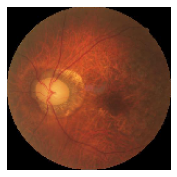



Some random transformation are:


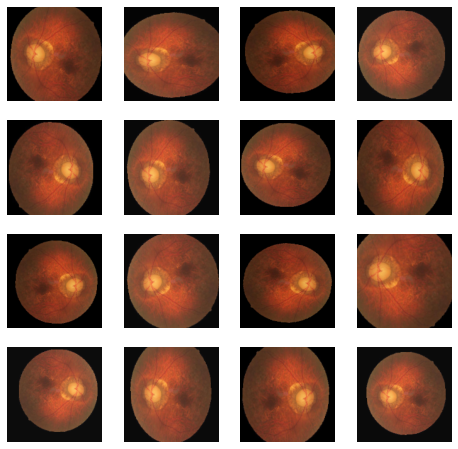

In [ ]:
# Look at the generator to see what is it doing
# --------------------------------------------------

rand_index = np.random.choice(len(X_train))
x_ = X_train[rand_index]
y_ = y_train[rand_index]
disease = CLASSES_NAMES[int(y_)]

print(f"Image with index = {rand_index} has label {y_} and disease: {disease}")
plt.imshow(x_)
plt.axis('off')
plt.show()
print("\n\nSome random transformation are:")

w = 10
h = 10
fig = plt.figure(figsize=(8, 8))
columns = 4
rows = 4
for i in range(1, columns*rows +1):
    img = image_datagen.random_transform(x_)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis('off')
plt.show()

## 1.3 Models 

### 1.3.1 Model 01: 151x151x3 + Transfer Learning + Dense(128) + BN + Dropout + Dense(K) (with train augmentation)

In [ ]:
def Model_01(height:int, width:int, channels:int, number_classes:int = CLASSES):
    
    input_shape_ = (height, width, channels)
    base_model = keras.applications.Xception(
        weights = 'imagenet',  # Load weights pre-trained on ImageNet.
        input_shape = input_shape_,
        include_top = False, # Do not include the ImageNet classifier at the top.
        pooling = None
    )     
 
    # Here we freeze the base model
    base_model.trainable = False

    # Create a new model on top
    inputs = tf.keras.Input(shape = input_shape_)
    x = base_model(inputs, training = False)
                          
    # Convert features of shape `base_model.output_shape[1:]` to vectors
    x = keras.layers.GlobalAveragePooling2D()(x)

    # Now the architecture to be tested
    x = keras.layers.Dense(128)(x) 
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.5)(x)
    output = keras.layers.Dense(units = number_classes, activation = "softmax")(x)
    model = keras.Model(inputs, output)
    
    # Compilation
    model.compile(optimizer = keras.optimizers.Adam(learning_rate = 0.001), 
                  loss = "categorical_crossentropy", 
                  metrics = keras.metrics.Recall(name="recall"))

    print(model.summary())

    return model

In [ ]:
# The first time we create the model from scratch and pass the Keras.Model to the Model class
#new_m01 = Model_01(151, 151, 3)
#m01 = Model("01", new_m01)

# Another time we just instantiate the class and the intance will look for the saved model
m01 = Model("01")

In [ ]:
# Training
# m01.train(X_train, Y_train, X_test, Y_test, epochs = 1, batch_size = 5)

# Train with data augmentation
m01.train_with_augmentation(train_generator, X_test, Y_test, epochs = 50)

Successfully loaded model Models/m01.h5
Last training history read, last epoch was #55
Epoch 1/50
1/1 [==============================] - 4s 4s/step - loss: 0.9692 - recall: 0.6719 - val_loss: 0.7520 - val_recall: 0.6559

Epoch 00001: val_recall did not improve from 0.66308
Epoch 2/50
1/1 [==============================] - 1s 1s/step - loss: 0.5515 - recall: 0.7812 - val_loss: 0.7486 - val_recall: 0.6541

Epoch 00002: val_recall did not improve from 0.66308
Epoch 3/50
1/1 [==============================] - 1s 1s/step - loss: 0.6557 - recall: 0.7344 - val_loss: 0.7490 - val_recall: 0.6505

Epoch 00003: val_recall did not improve from 0.66308
Epoch 4/50
1/1 [==============================] - 1s 707ms/step - loss: 1.1189 - recall: 0.6000 - val_loss: 0.7509 - val_recall: 0.6416

Epoch 00004: val_recall did not improve from 0.66308
Epoch 5/50
1/1 [==============================] - 1s 1s/step - loss: 0.9394 - recall: 0.6719 - val_loss: 0.7558 - val_recall: 0.6326

Epoch 00005: val_recall did 

Last training history read, last epoch was #105
Index(['epoch', 'loss', 'recall', 'val_loss', 'val_recall'], dtype='object')


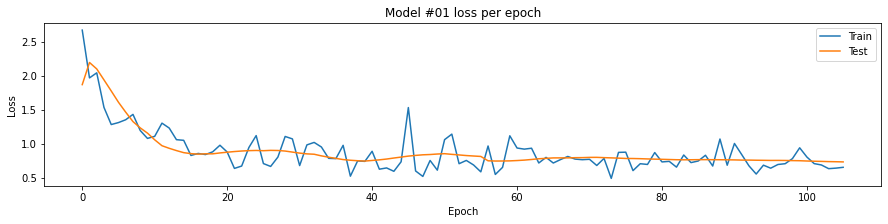

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Let's check the training curves
m01.plot_learning_curves()
accuracy, precision, recall, f1, confusion = m01.get_performance(X_test, y_test)

### 1.3.2. Model 01b: 151x151x3 + Transfer Learning + Dense(128) + BN + Dropout + Dense(K) (without train augmentation)

In [ ]:
# The first time we create the model from scratch and pass the Keras.Model to the Model class
new_m01b = Model_01(151, 151, 3)
m01b = Model("01b", new_m01b)

# Another time we just instantiate the class and the intance will look for the saved model
#m01 = Model("01")

83689472/83683744 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 151, 151, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
batch_normalization_4 (Batch (None, 128)               512       
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
______________________________________________________________

In [ ]:
m01b.train(X_train, Y_train, X_test, Y_test, epochs = 100, batch_size = 128)

Previous saved model not found
Last training history not found, starting now from epoch #1
Epoch 1/100
1/1 [==============================] - 5s 5s/step - loss: 2.2890 - recall: 0.2266 - val_loss: 1.1126 - val_recall: 0.3208

Epoch 00001: val_recall improved from -inf to 0.32079, saving model to Models/m01b.h5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
1/1 [==============================] - 0s 462ms/step - loss: 1.7177 - recall: 0.4141 - val_loss: 1.3162 - val_recall: 0.3584

Epoch 00002: val_recall improved from 0.32079 to 0.35842, saving model to Models/m01b.h5
Epoch 3/100
1/1 [==============================] - 0s 459ms/step - loss: 1.5458 - recall: 0.5000 - val_loss: 1.4594 - val_recall: 0.3781

Epoch 00003: val_recall improved from 0.35842 to 0.37814, saving model to Models/m01b.h5
Epoch 4/100
1/1 [==============================] - 0s 459ms/step - loss: 1.1235 - recall: 0.6094 - val_loss: 1.5643 - val_recall: 0.3925

Epoch 00004: val_recall improved from 0.37814 to 0.39247, saving model to Models/m01b.h5
Epoch 5/100
1/1 [==============================] - 0s 463ms/step - loss: 1.2992 - recall: 0.6328 - val_loss: 1.6396 - val_recall: 0.4229

Epoch 00005: val_recall improved from 0.39247 to 0.42294, saving model to Models/m01b.h5
Epoch 6/100
1/1 [==============================] - 0s 462ms/step - loss: 1.3272 - recall: 0.

Last training history read, last epoch was #99
Index(['epoch', 'loss', 'recall', 'val_loss', 'val_recall'], dtype='object')


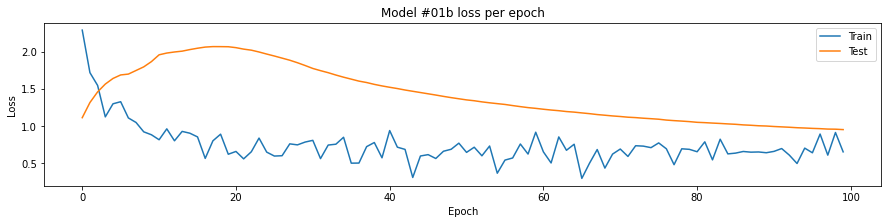

In [ ]:
m01b.plot_learning_curves()

### 1.3.3. Model 02: 151x151x3 + Transfer Learning + Dense(128) + BN + Dropout + Dense(128) + Dense(K) (with train augmentation)

In [ ]:
def Model_02(height:int, width:int, channels:int, number_classes:int = CLASSES):
    
    input_shape_ = (height, width, channels)
    base_model = keras.applications.Xception(
        weights = 'imagenet',  # Load weights pre-trained on ImageNet.
        input_shape = input_shape_,
        include_top = False, # Do not include the ImageNet classifier at the top.
        pooling = None
    )     
 
    # Here we freeze the base model
    base_model.trainable = False

    # Create a new model on top
    inputs = tf.keras.Input(shape = input_shape_)
    x = base_model(inputs, training = False)
                          
    # Convert features of shape `base_model.output_shape[1:]` to vectors
    x = keras.layers.GlobalAveragePooling2D()(x)

    # Now the architecture to be tested
    x = keras.layers.Dense(128)(x) 
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.5)(x)
    x = keras.layers.Dense(128)(x)
    output = keras.layers.Dense(units = number_classes, activation = "softmax")(x)
    model = keras.Model(inputs, output)
    
    # Compilation
    model.compile(optimizer = keras.optimizers.Adam(learning_rate = 0.001), 
                  loss = "categorical_crossentropy", 
                  metrics = keras.metrics.Recall(name="recall"))

    return model

In [ ]:
# The first time we create the model from scratch
#new_m02 = Model_02(151, 151, 3)
#m02 = Model("02", new_m02)

# Another time we just instantiate the class and the intance will look for the saved model
m02 = Model("02")

In [ ]:
# Train with data augmentation now
m02.train_with_augmentation(train_generator, X_test, Y_test, epochs = 200)

Successfully loaded model Models/m02.h5
Last training history read, last epoch was #99
Epoch 1/200
1/1 [==============================] - 4s 4s/step - loss: 0.5542 - recall: 0.7422 - val_loss: 0.6445 - val_recall: 0.6756

Epoch 00001: val_recall improved from -inf to 0.67563, saving model to Models/m02.h5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/200
1/1 [==============================] - 1s 1s/step - loss: 0.6527 - recall: 0.7188 - val_loss: 0.6449 - val_recall: 0.6703

Epoch 00002: val_recall did not improve from 0.67563
Epoch 3/200
1/1 [==============================] - 1s 1s/step - loss: 0.5327 - recall: 0.7578 - val_loss: 0.6435 - val_recall: 0.6667

Epoch 00003: val_recall did not improve from 0.67563
Epoch 4/200
1/1 [==============================] - 1s 1s/step - loss: 0.4664 - recall: 0.7656 - val_loss: 0.6455 - val_recall: 0.6685

Epoch 00004: val_recall did not improve from 0.67563
Epoch 5/200
1/1 [==============================] - 1s 1s/step - loss: 0.4388 - recall: 0.8125 - val_loss: 0.6474 - val_recall: 0.6685

Epoch 00005: val_recall did not improve from 0.67563
Epoch 6/200
1/1 [==============================] - 1s 1s/step - loss: 0.4626 - recall: 0.7891 - val_loss: 0.6508 - val_recall: 0.6720

Epoch 00006: val_recall did not improve from 0.67563
Epoch 7/200
1/1 [==============================] - 1s 1s/ste

Last training history read, last epoch was #299
Index(['epoch', 'loss', 'recall', 'val_loss', 'val_recall'], dtype='object')


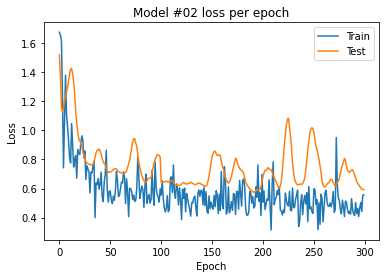

In [ ]:
m02.plot_learning_curves()

In [ ]:
# Retrieve the performance
M02 = Model("02")
M02.load_model()
accuracy, precision, recall, f1, confusion = M02.get_performance(X_test, Y_test, y_test)
print(f"accuracy is {accuracy}")
print(f"precision is {precision}")
print(f"recall is {recall}")
print(f"f1 is {f1}")
print(confusion)

Successfully loaded model Models/m02.h5
accuracy is 0.7777777777777778
precision is 0.7895812546690975
recall is 0.7777777777777778
f1 is 0.7780503808575837
[[121  13  24   0]
 [  1 178  42   0]
 [  1  37 135   0]
 [  0   1   5   0]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 1.4 Summary

**a. Perform 70/30 data split and report performance scores on the test data set.**

In [ ]:
# I tried 3 models and trained them for ~100 iterations.
# The performance is shown now:
ids = ["01b", "01", "02", ]
methods=["TL + Augmentation: No  - Dense(128) - BN - Dropout",
         "TL + Augmentation: Yes - Dense(128) - BN - Dropout",
         "TL + Augmentation: Yes - Dense(128) - BN - Dropout + Dense(128)"]

my_headers = ["Method","Accuracy","Precision","Recall", "F1 Score"]
info = []

for i, id in enumerate(ids):
    m = Model(id)
    m.load_model()
    accuracy, precision, recall, f1, confusion = m.get_performance(X_test, y_test)
    row = []
    method = methods[i]
    row.append(method)
    row.append(round(accuracy,3))
    row.append(round(precision,3))
    row.append(round(recall,3))
    row.append(round(f1,3))
    info.append(row)

print()
print("PERFORMANCE OF METHODS ON TEST SET:")
print()
print(tabulate(info, headers = my_headers))

Successfully loaded model Models/m01b.h5
Successfully loaded model Models/m01.h5


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Successfully loaded model Models/m02.h5

PERFORMANCE OF METHODS ON TEST SET:

Method                                                             Accuracy    Precision    Recall    F1 Score
---------------------------------------------------------------  ----------  -----------  --------  ----------
TL + Augmentation: No  - Dense(128) - BN - Dropout                    0.661        0.701     0.661       0.653
TL + Augmentation: Yes - Dense(128) - BN - Dropout                    0.717        0.717     0.717       0.712
TL + Augmentation: Yes - Dense(128) - BN - Dropout + Dense(128)       0.778        0.79      0.778       0.778


**b. You can choose to apply any data augmentation strategy**

* The augmentation strategy is shown on section 1.2
* This strategy increased the recall of method 1 from 66% to 71% on method 2 (+5% gain on recall)


**Explain your methods and rationale behind parameter selection.**

* I transformed the original problem from a multi-label to a single-label because the later was easier to manipulate.
* The number of combinations for a single-label problem did not explode (there were 4 classes at the end: normal, glaucoma, diabetic retinopathy and glaucoma + diabetic retinopathy)
* Given the single label multi class problem, I used a softmax activation function in the last dense layer to classify
* I chose to do transfer learning because it gave me a nice starting point with a very simple and fast model to train, and this allowed me not to think of any convolutional architecture to train from scratch.
* If a certain threshold metric was mandatory to get, I would have tested if the methods I created satisfy that metric (for instance, 95% recall), and if the best did not make it, then in that case I would have tried more complex models.
* The single metric I used as evaluation was the recall, given the importance of detecting true positives on this medical domain
* All the decision of the modelling were based on this metric (recall on the test set)
* I added data augmentation, tested it, and it showed that it added +5% on the test set recall
* Dropout helped with the regularization (initially I had a model without Dropout and the Variance was huge)
* These 2 initial models had a bias problem to tackle, so I added an extra dense layer and it proved to be useful (increased the recall from 71% to 78%)
* Adam optimizer proved to be stable and good for the optimization, so I did not try more optimizers methods
* The target variable is one-hot-encoded so the loss function is categorical_crossentropy

**c. Show Training-validation curves to ensure overfitting and underfitting is avoided.**

Successfully loaded model Models/m01b.h5
Last training history read, last epoch was #99
Index(['epoch', 'loss', 'recall', 'val_loss', 'val_recall'], dtype='object')


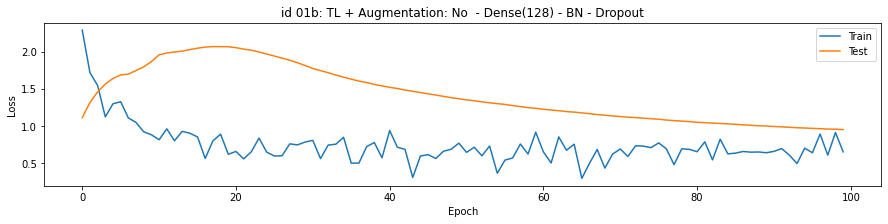

Successfully loaded model Models/m01.h5
Last training history read, last epoch was #105
Index(['epoch', 'loss', 'recall', 'val_loss', 'val_recall'], dtype='object')


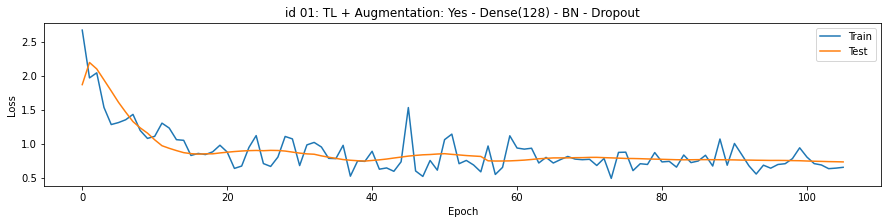

Successfully loaded model Models/m02.h5
Last training history read, last epoch was #299
Index(['epoch', 'loss', 'recall', 'val_loss', 'val_recall'], dtype='object')


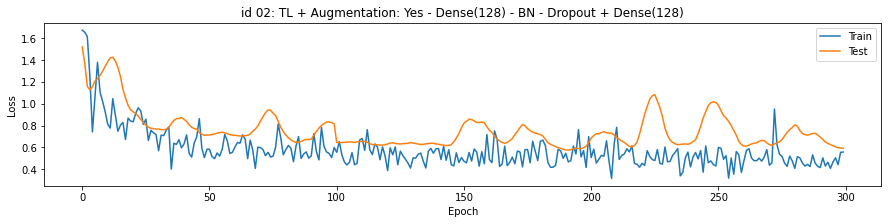

In [ ]:
# The use of data augmentation really helped with the overfitting

ids = ["01b", "01", "02", ]
methods=["TL + Augmentation: No  - Dense(128) - BN - Dropout",
         "TL + Augmentation: Yes - Dense(128) - BN - Dropout",
         "TL + Augmentation: Yes - Dense(128) - BN - Dropout + Dense(128)"]

for i, id in enumerate(ids):
    m = Model(id)
    m.load_model()
    m.plot_learning_curves("id " + ids[i] + ": " + methods[i])

# Task 2: Explainability of regions for glaucoma and diabetic retinopathy

For explaning the regions I'm going to do the following:
* Use a model from the previous step (Model id 01 in this case)
* Predict on the train set
* Use the LIME library to get explanations on the prediction
* LIME stands for (Local Interpretable Model-agnostic Explanations). Given an image x, a model M, and a prediction p, it performs local perturbations to x in order the detect which pixels have the largest weights for the probability prediction p.
* I'll focus on explaining images that had a high accuracy on the prediction

In [ ]:
# Select a model and make the predictions on the train set
m_ = Model("01")
m_.load_model()
model = m_.keras_model
pred = model.predict(X_train)
np.set_printoptions(suppress=True)

Successfully loaded model Models/m01.h5


In [ ]:
# Now we calculate the average diff on the predictions
avg_abs_diff = np.average(np.abs(pred - Y_train), axis = 1)
print(avg_abs_diff.shape)
print(f"pred are\n{pred[0:5]}")
print(f"truth is\n{Y_train[0:5]}")
print(f"avg_abs_diff is\n{avg_abs_diff[0:5]}")

(1300,)
pred are
[[0.4059844  0.04908945 0.48014718 0.06477895]
 [0.25450832 0.03846894 0.636493   0.07052975]
 [0.04003693 0.84947723 0.04294673 0.0675391 ]
 [0.9512716  0.00437406 0.01951065 0.02484361]
 [0.00091784 0.9731515  0.01676036 0.00917028]]
truth is
[[0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]]
avg_abs_diff is
[0.2599264  0.1817535  0.07526138 0.02436418 0.01342424]


In [ ]:
# Here we store the predictions and truth of the images
pred_diabeticretinopathy = pred[:,1]
pred_glaucoma = pred[:,2]
true_diabeticretinopathy = Y_train[:,1].numpy()
true_glaucoma = Y_train[:,2].numpy()

In [ ]:
print(pred_diabeticretinopathy[0:5])
print(true_diabeticretinopathy[0:5])

[0.15959737 0.05811303 0.9783564  0.01120916 0.96973366]
[0. 0. 1. 0. 1.]


In [ ]:
!pip install lime
from lime import lime_image


     |████████████████████████████████| 275 kB 5.5 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=cf11a719e025914cd42f1815681bc6f808246eb59ba35d6c87f74808205f25c7
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [ ]:
# Creating this array Z to then take a look at the images with highest score
# index / prediction / truth / avg_abs_diff / score = pred * (1 - avg_abs_diff)
prediction = pred_diabeticretinopathy
truth = true_diabeticretinopathy

m = len(prediction)
Z = np.zeros((m,5))
Z[:,0] = np.arange(m)                   # Column 1 = indices
Z[:,1] = prediction                     # Column 2 = prediction
Z[:,2] = truth                          # Column 3 = truth
Z[:,3] = avg_abs_diff                   # Column 4 = avg_abs_diff
Z[:,4] = prediction * (1-avg_abs_diff)  # Column 5 = score
print("Unsorted Z matrix")
print(Z[0:10])
print()

# https://www.kite.com/python/answers/how-to-sort-the-rows-of-a-numpy-array-by-a-column-in-python#:~:text=argsort()%20to%20sort%20the,indices%20of%20the%20column%20a%20.
Z_sorted_by_score = np.around(Z[np.argsort(Z[:,4])], decimals = 3)
print("Sorted Z matrix better 10 results")
print(Z_sorted_by_score[1290:1300])

Unsorted Z matrix
[[0.         0.04908945 0.         0.25992641 0.03632981]
 [1.         0.03846894 0.         0.1817535  0.03147708]
 [2.         0.84947723 1.         0.07526138 0.7855444 ]
 [3.         0.00437406 0.         0.02436418 0.00426749]
 [4.         0.9731515  1.         0.01342424 0.96008772]
 [5.         0.00287612 0.         0.01514071 0.00283258]
 [6.         0.19826362 1.         0.40086818 0.11878604]
 [7.         0.57519704 1.         0.21240149 0.45302433]
 [8.         0.38206664 1.         0.3089667  0.26402077]
 [9.         0.31651813 1.         0.34174094 0.20835091]]

Sorted Z matrix better 10 results
[[1028.       0.991    1.       0.004    0.987]
 [ 129.       0.992    1.       0.004    0.988]
 [1139.       0.993    1.       0.004    0.989]
 [1061.       0.993    1.       0.003    0.99 ]
 [ 481.       0.994    1.       0.003    0.991]
 [ 348.       0.994    1.       0.003    0.991]
 [1246.       0.995    1.       0.002    0.993]
 [1226.       0.996    1.     

In [ ]:
def get_explanations(prediction, truth, number_explanations, disease, X_train, model):
    m = len(prediction)
    Z = np.zeros((m,5))
    Z[:,0] = np.arange(m)                   # Column 1 = indices
    Z[:,1] = prediction                     # Column 2 = prediction
    Z[:,2] = truth                          # Column 3 = truth
    Z[:,3] = avg_abs_diff                   # Column 4 = avg_abs_diff
    Z[:,4] = prediction * (1-avg_abs_diff)  # Column 5 = score    
    Z_sorted_by_score = np.around(Z[np.argsort(Z[:,4])], decimals = 3) #This is sorted from the least score to the max
    
    print("Explanations for disease: " + disease + ".\nMain explanatory pixels on the second column.\nGreen pixels increase the probability of the prediction\nRed pixels decrease it")

    fig, axs = plt.subplots(number_explanations, 3, figsize = (40,80))
    for i in range(number_explanations):

        # Select a row
        Z_row = Z_sorted_by_score[-1 - i]
        index = int(Z_row[0])
        image = X_train[index]
        pred =  Z_row[1]
        truth_ = Z_row[2]

        # Explain it
        print(f"Getting explanation #{i+1}")
        explainer = lime_image.LimeImageExplainer()
        explanation = explainer.explain_instance(image.astype('double'), 
                                         model.predict,  
                                         top_labels = 1, 
                                         hide_color = 0, 
                                         num_samples = 1000
                                         )
        temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
        temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

        # Plot it
        axs[i,0].imshow(image)
        axs[i,0].axis('off')
        axs[i,0].set_title("Index image: "+str(index))
        axs[i,1].imshow(mark_boundaries(temp_1, mask_1))
        axs[i,1].axis('off')
        axs[i,1].set_title("Prediction = "+str(pred) + "\nTruth = "+str(truth_))
        axs[i,2].imshow(mark_boundaries(temp_2, mask_2))
        axs[i,2].axis('off')
    
    plt.tight_layout()
    plt.show()

**For diabetic retinopathy identification**
* Let's look at a diagram explaining the difference between a diabetic retinopathy v/s a normal one

(-0.5, 749.5, 402.5, -0.5)

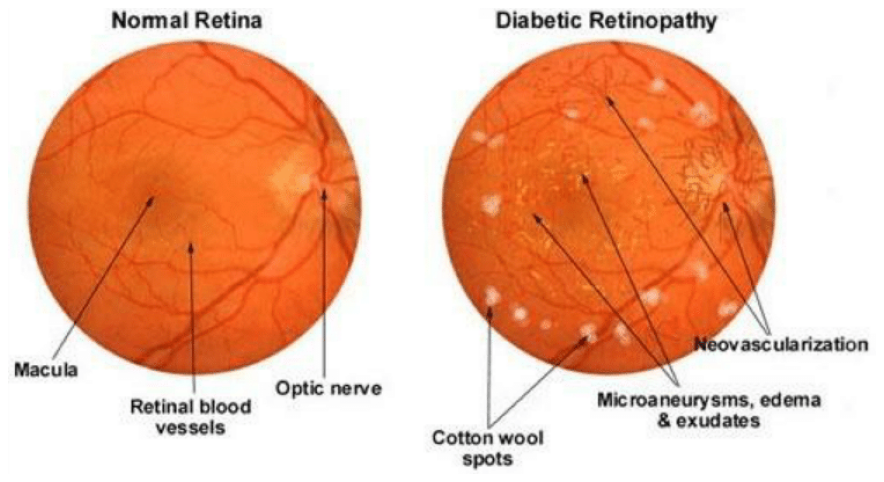

In [ ]:
img = mpimg.imread("Difference-between-Normal-Retina-and-Diabetic-Retinopathy.png")
from matplotlib.pyplot import figure
figure(figsize=(14,12), dpi=80)
imgplot = plt.imshow(img)
plt.axis("off")

**For diabetic retinopathy identification lets look at the areas below**
* It seems that the area of the image that gets the more impact on the prediction are those microaneurysm, edemas and exudates
* On some images the neovascularization is dettected as well
* The cotton wool spots on this 10 top images did not attract that much attention

Explanations for disease: Diabetic Retinopathy.
Main explanatory pixels on the second column.
Green pixels increase the probability of the prediction
Red pixels decrease it
Getting explanation #1



Getting explanation #2



Getting explanation #3



Getting explanation #4



Getting explanation #5



Getting explanation #6



Getting explanation #7



Getting explanation #8



Getting explanation #9



Getting explanation #10


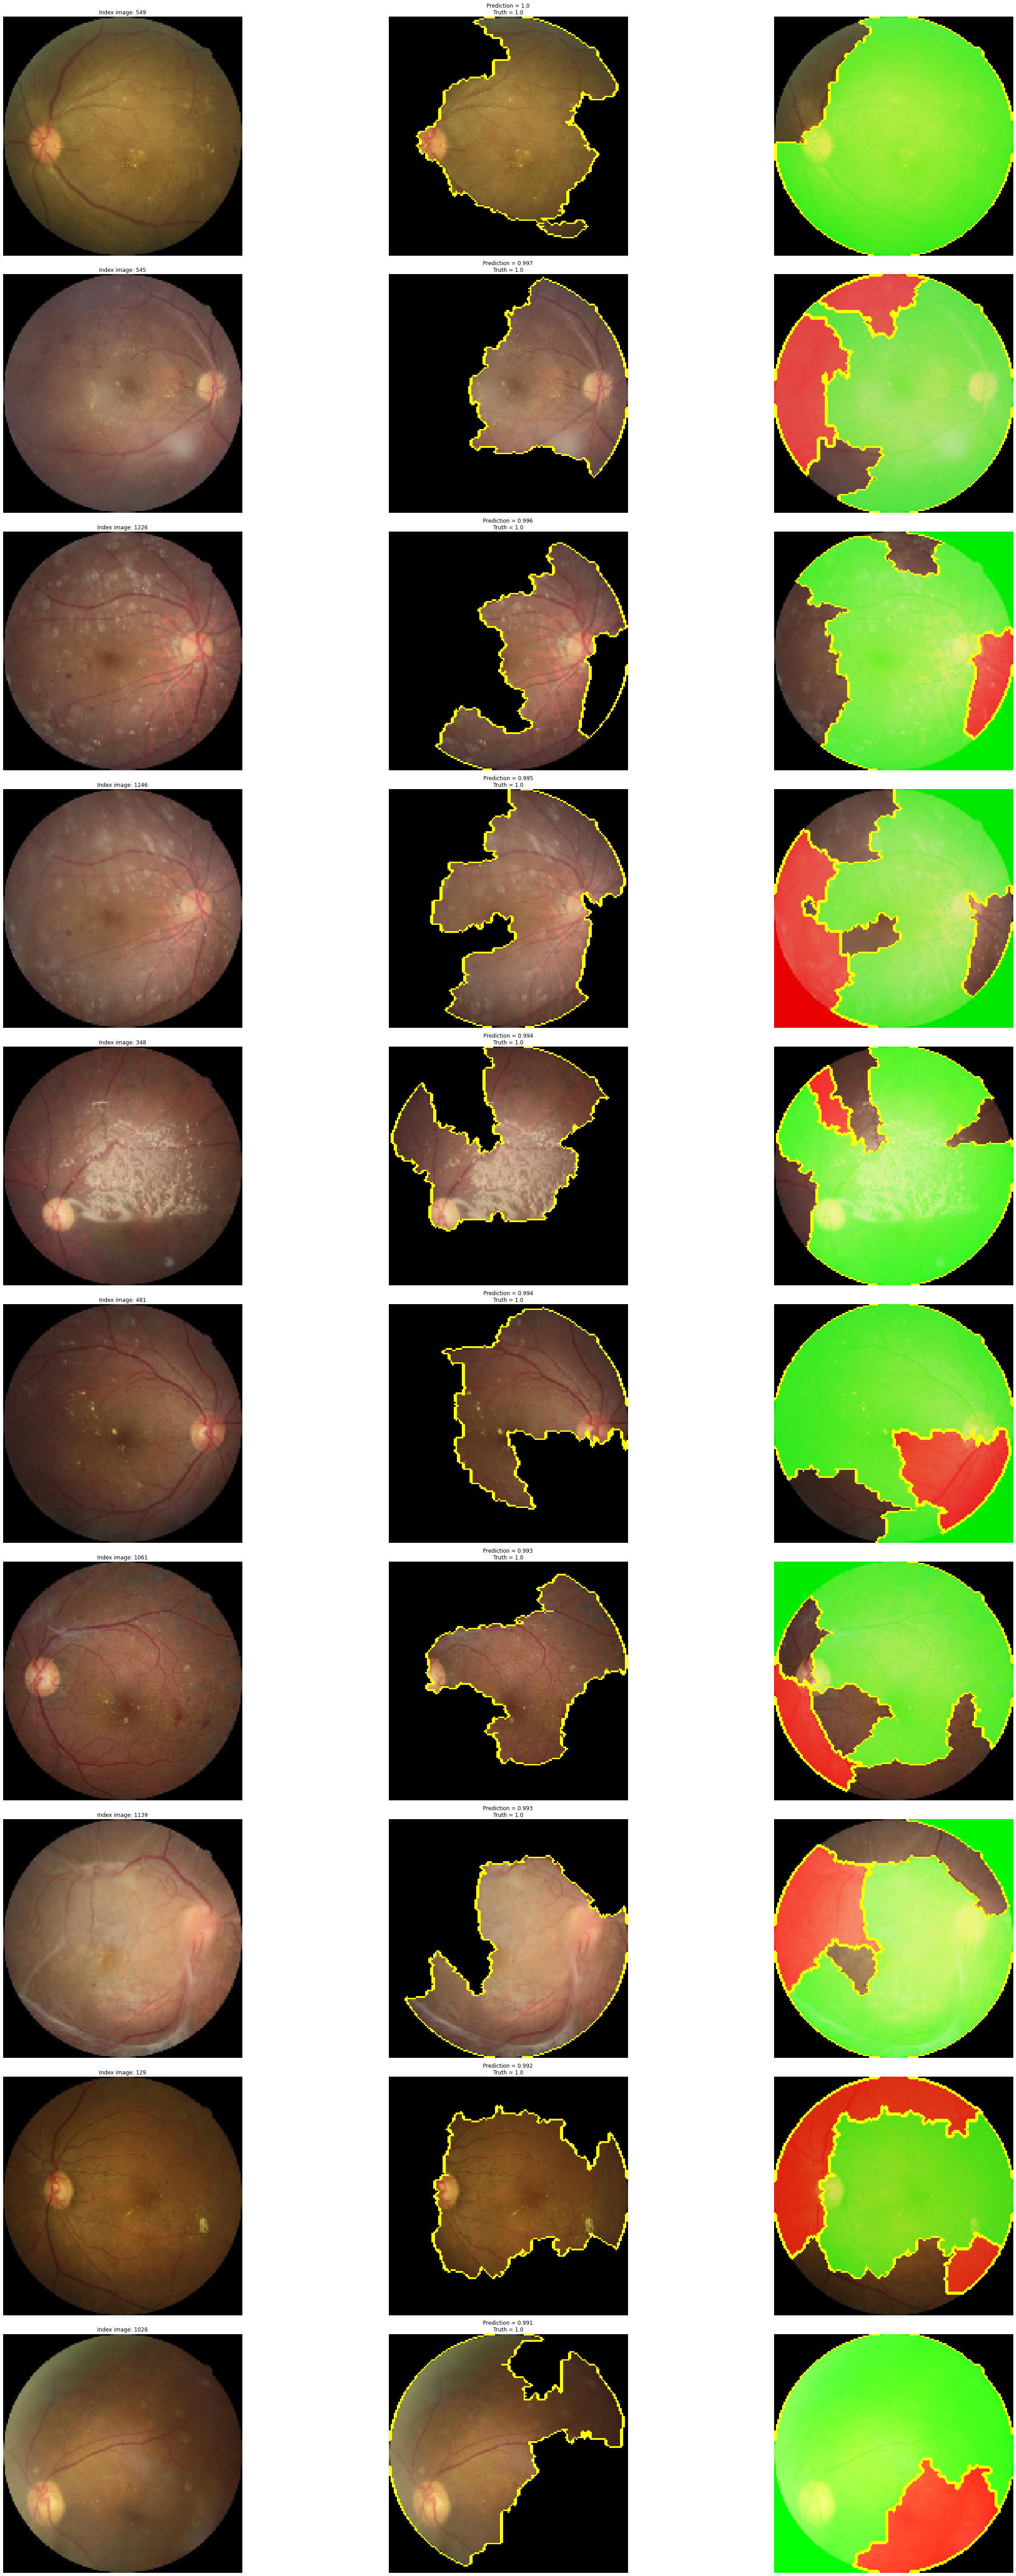

In [ ]:
get_explanations(pred_diabeticretinopathy, true_diabeticretinopathy, 10, "Diabetic Retinopathy", X_train, model)

**For glaucoma identification**
* Let's look at a diagram explaining the difference between a glaucoma v/s a normal one

(-0.5, 1802.5, 1074.5, -0.5)

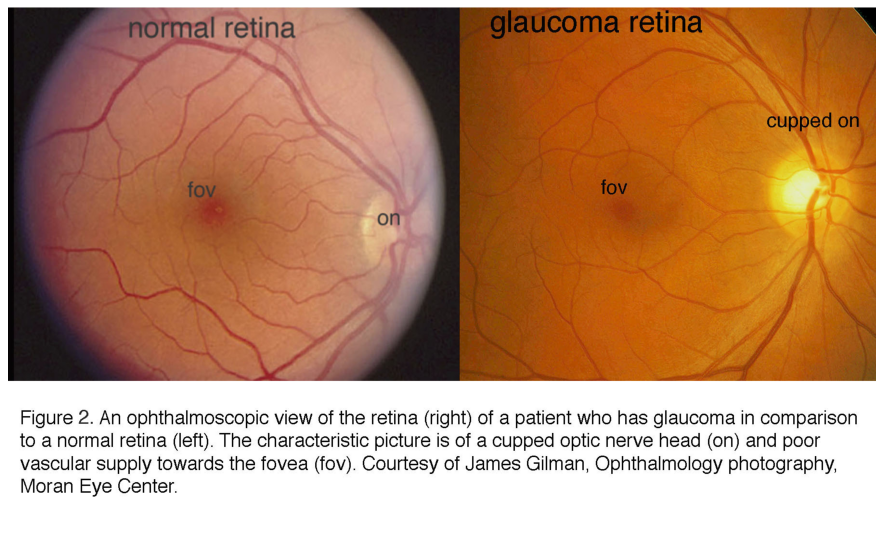

In [ ]:
from matplotlib.pyplot import figure
figure(figsize=(14,12), dpi=80)
img = mpimg.imread("glaucoma and normal.jpg")
imgplot = plt.imshow(img)
plt.axis("off")

**For glaucoma lets look at the areas below**
* Most of the times the model detects the cupped optic nerve
* In other images the poor vascular supply towards the fovea is detected as well

Explanations for disease: Glaucoma.
Main explanatory pixels on the second column.
Green pixels increase the probability of the prediction
Red pixels decrease it
Getting explanation #1



Getting explanation #2



Getting explanation #3



Getting explanation #4



Getting explanation #5



Getting explanation #6



Getting explanation #7



Getting explanation #8



Getting explanation #9



Getting explanation #10


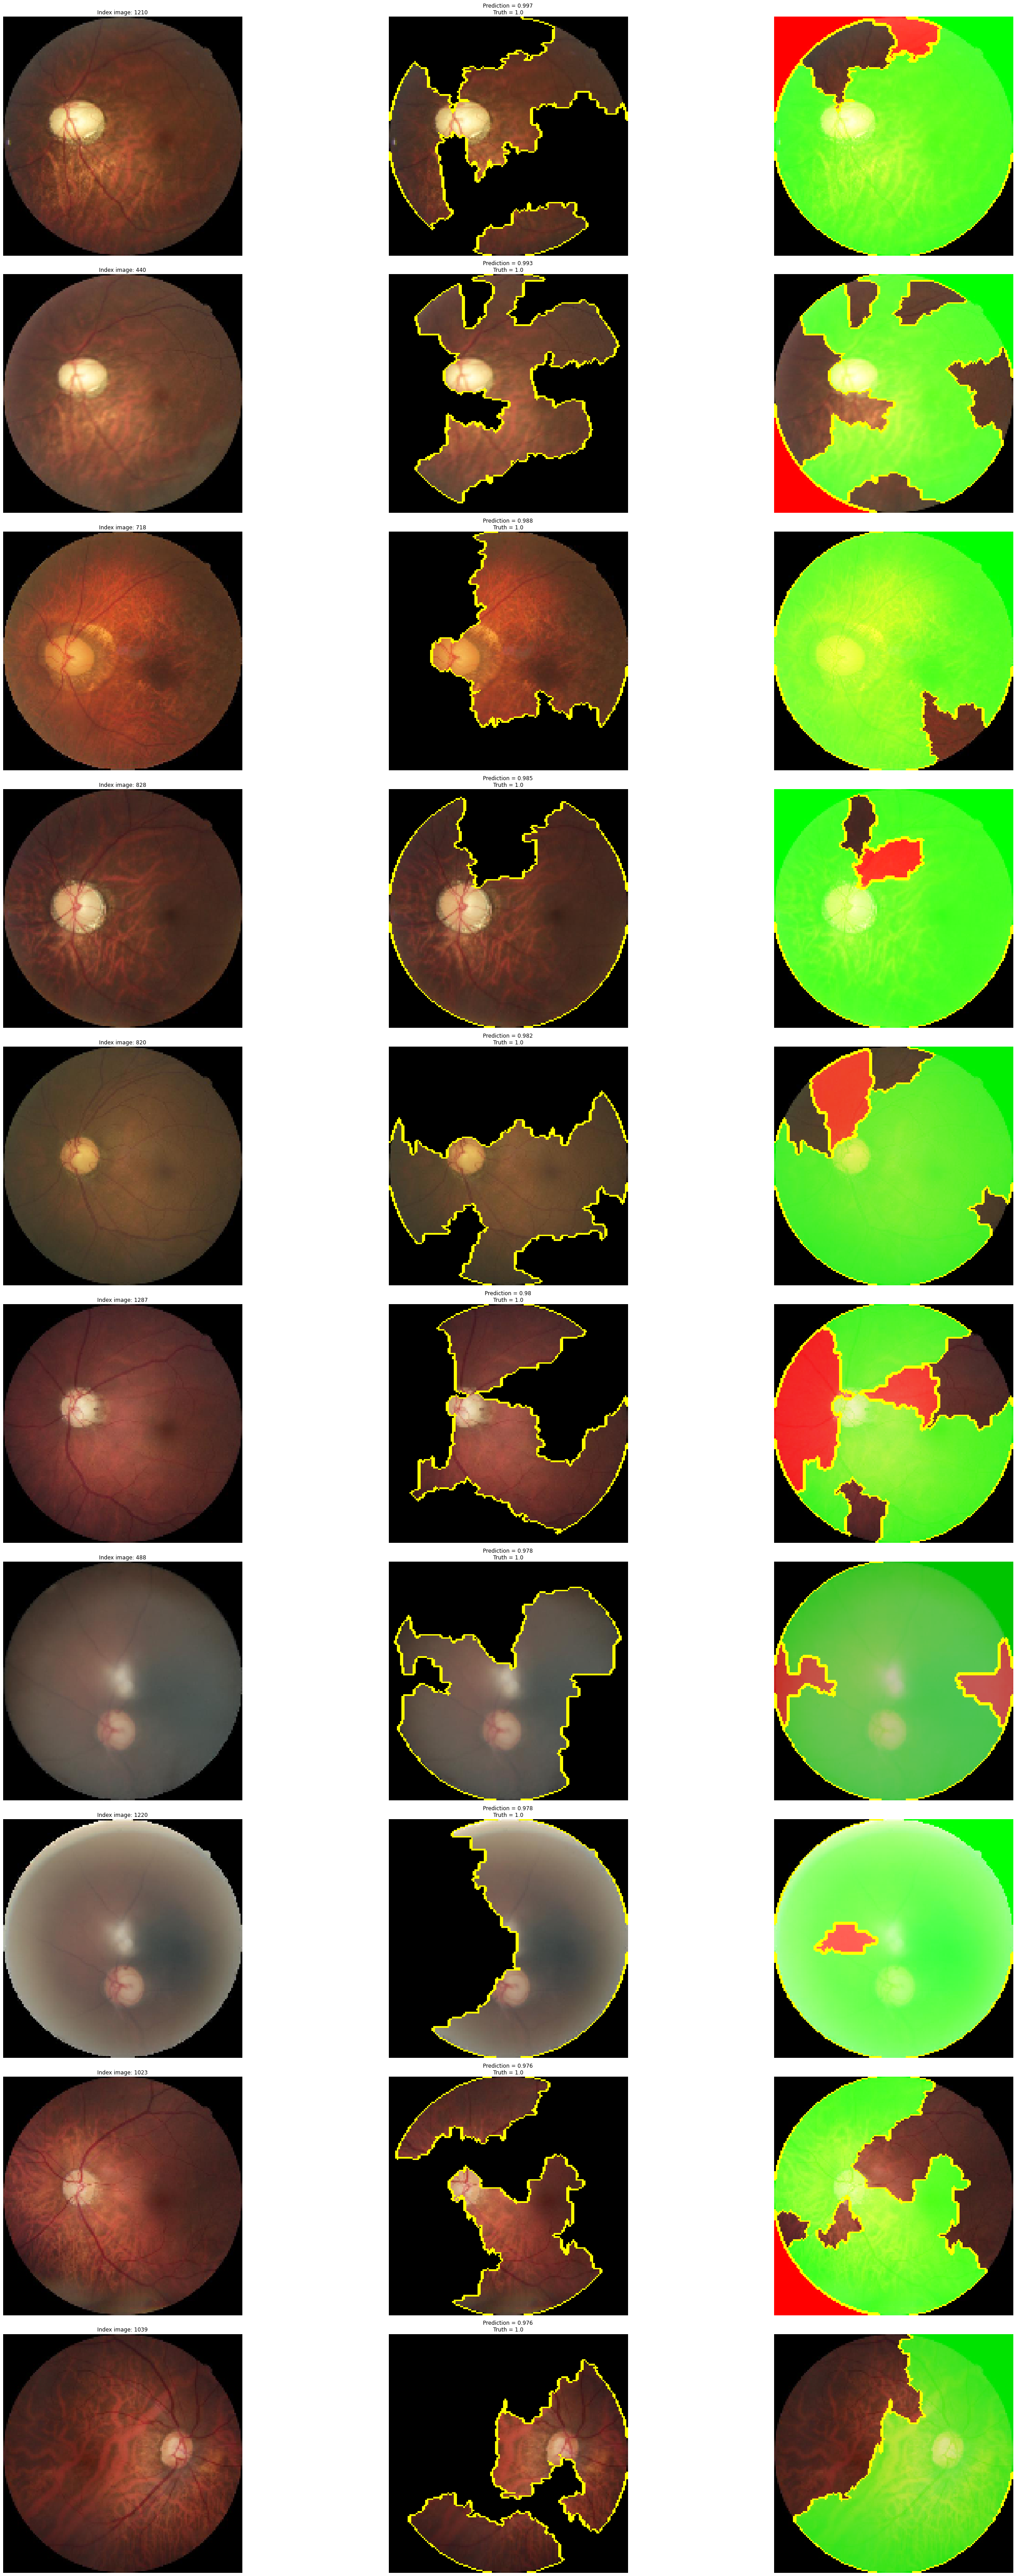

In [ ]:
get_explanations(pred_glaucoma, true_glaucoma, 10, "Glaucoma", X_train, model)

# Task 3: Self-supervised learning

**What's the plan:**
* Load the unlabeled dataset and save it to disk with the same resolution as the other models 151 x 151 x 3
* Load it and normalize it, this will be called X_unlabeled
* Pass this dataset through the model and retrieve the features from the last layer that does not perform classification (feature extraction)
* Train a LabelSpreading model from ScikitLearn with the training set X_train with a 70/30 split within it. By doing this we can perform a quick hyperparameter search
* With the best hyperparameters found create a model and train it with X_enhanced = X_train + X_unlabeled
* Retrieve the labels for X_unlabeled (transduction)
* Create a new dataset X_enhanced, which is now fully labeled
* Train model id=02 again (with data augmentation as well) and compare the results

## 3.1 Load and save the unlabeled dataset on google drive

In [ ]:
def load_unlabeled_images_and_save_X(height: int, width: int, channels: int, input_folder = FOLDER_IMAGES_TEST, output_folder = FOLDER_X_TEST):
    """
    Creates X array from the test data set and reshapes it to the desired resolution.
    Then saves this array with names:
    Name for X: X_unlabeled_h_x_w_x_c.npy    
    input_folder: folder to read the images    
    X shape -> (m, h, w, c)    

    Arguments:
        height (int): image height dimension
        width (int): image width dimension
        channels (int): image channel dimension    
    
    Returns:
        None
    """
    
    # Count the number of files
    _, _, files_paths = next(os.walk(input_folder))
    m = len(files_paths)
    print(f"there are {m} files in {input_folder}")

    # Now initialize the X and y array
    print(f"Initialiazing X to shape {(m, height, width, channels)}")
    X = np.zeros((m, height, width, channels))    

    # Now read the images and put the info onto X and y
    for j, file_name in enumerate(files_paths):

        if j % 100 == 0:
            print(f"Reading image {j+1} / {m}")

        # Filling X    
        path = input_folder + file_name
        image_resized = load_img(path, target_size = (height, width))
        x_image_array = np.reshape(image_resized, (1,height, width, channels))
        X[j] = x_image_array
    
    # Saving the dataset now
    X_name = output_folder + "X_unlabeled_" + str(height) + "_x_" + str(width) + "_x_" + str(channels) + ".npy"
    np.save(X_name, X)    
    print(f"Saved X as {X_name}")   

In [ ]:
def load_unlabeled_dataset(height: int, width: int, channels: int, dataset_folder = FOLDER_X_TEST):
    """
    Loads a dataset with dimensions h x w

    Arguments:
        height (int): image height dimension
        width (int): image width dimension
        channels (int): image channel dimension
        dataset_folder: folder to search for the X array
    
    Returns:
        X (ndarray): of shape (m, h, w, 3)    
    """
    X_path = dataset_folder + "X_unlabeled_" + str(height) + "_x_" + str(width) + "_x_" + str(channels) + ".npy"
    X = np.load(X_path)
    print(f"X has shape {X.shape}")
    return X

In [ ]:
# Run this cell to preprocess this dataset
load_unlabeled_images_and_save_X(151,151,3)

In [ ]:
# In this cell the dataset is loadad
X_unlabeled = load_unlabeled_dataset(151,151,3)
X_unlabeled = normalize(X_unlabeled)

X has shape (350, 151, 151, 3)


##3.2 Pass the unlabeled dataset through the model and retrieve output from the layer before classfication

In [ ]:
# Instantiate a model from the list and name it "model"
m_ = Model("02")
m_.load_model()
model = m_.keras_model
model.summary()

Successfully loaded model Models/m02.h5
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 151, 151, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               262272    
_________________________________________________________________
batch_normalization_9 (Batch (None, 128)               512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)    

In [ ]:
# Define the extractor layer
# Source: https://keras.io/getting_started/faq/#how-can-i-obtain-the-output-of-an-intermediate-layer-feature-extraction
layer_name = "dense_3" # this is the last dense layer before the classification is made
intermediate_layer_model = keras.Model(
    inputs = model.input,
    outputs = model.get_layer(layer_name).output)

In [ ]:
# I ran out of memory when trying to get the features for X_train, so I will do this in 3 steps by saving the features to disk

# Step 1
#X_train_features_1 = intermediate_layer_model(X_train[0:500]).numpy() #.numpy() to convert to numpy array
#print(f"X_train_features_1 has shape {X_train_features_1.shape}")
#np.save("X_train_features_1.npy", X_train_features_1)

# Step 2
#X_train_features_2 = intermediate_layer_model(X_train[500:1000]).numpy() #.numpy() to convert to numpy array
#print(f"X_train_features_2 has shape {X_train_features_2.shape}")
#np.save("X_train_features_2.npy", X_train_features_2)

# Step 3
#X_train_features_3 = intermediate_layer_model(X_train[1000:]).numpy() #.numpy() to convert to numpy array
#print(f"X_train_features_3 has shape {X_train_features_3.shape}")
#np.save("X_train_features_3.npy", X_train_features_3)

X_train_features_3 has shape (300, 128)


In [ ]:
# Now I load
X_train_features_1 = np.load("X_train_features_1.npy")
X_train_features_2 = np.load("X_train_features_2.npy")
X_train_features_3 = np.load("X_train_features_3.npy")
X_train_features = np.concatenate((X_train_features_1, X_train_features_2, X_train_features_3), axis = 0)

X_train_features has shape (1300, 128)


In [ ]:
# Here I load the unlabeled features
X_unlabeled_features = intermediate_layer_model(X_unlabeled).numpy()

In [ ]:
print(f"X_train_features shape is {X_train_features.shape}")
print(f"y_train shape is {y_train.shape}")
print(f"X_unlabeled_features shape is {X_unlabeled_features.shape}")

X_train_features shape is (1300, 128)
y_train shape is (1300,)
X_unlabeled_features shape is (350, 128)


## 3.3 Train the Label Propagation model with a quick hyperparameter tuning

In [ ]:
# https://machinelearningmastery.com/semi-supervised-learning-with-label-spreading/
# https://scikit-learn.org/stable/auto_examples/semi_supervised/plot_label_propagation_digits.html

# Prepare the dataset now:
# I'll take the X_train_features and perform a split of 70/30 for hyperparameter tunning
X_LP_1, X_LP_2, y_LP_1, y_LP_2 = train_test_split(X_train_features, y_train, train_size = 0.7, random_state = 10, stratify = y_train)

# y_LP_2 will be the test
y_LP_2_unlabeled = np.full(y_LP_2.shape, fill_value = -1)

# Save the indices now
indices = np.arange(len(X_train_features))
test_indices = indices[len(y_LP_1):]
print(f"indices shape is {indices.shape}")
print(f"test_indices shape is {test_indices.shape}")

# Final LP training dataset
X_LP = np.concatenate((X_LP_1, X_LP_2), axis = 0)
y_LP = np.concatenate((y_LP_1, y_LP_2_unlabeled), axis = 0)

print(f"X_LP_1 shape is {X_LP_1.shape}")
print(f"X_LP_2 shape is {X_LP_2.shape}")
print(f"X_LP shape is {X_LP.shape}")
print(f"y_LP_1 shape is {y_LP_1.shape}")
print(f"y_LP_2_unlabeled shape is {y_LP_2_unlabeled.shape}")
print(f"y_LP shape is {y_LP.shape}")

indices shape is (1300,)
test_indices shape is (391,)
X_LP_1 shape is (909, 128)
X_LP_2 shape is (391, 128)
X_LP shape is (1300, 128)
y_LP_1 shape is (909,)
y_LP_2_unlabeled shape is (391,)
y_LP shape is (1300,)


In [ ]:
# Define the grid search over the hyperparameters now:
hyper1_kernels = ["knn", "rbf"]
hyper2_gamma = [0.05, 0.07, 0.1, 0.2, 0.3, 0.4, 0.5]
hyper3_neighbors = [2,3,4,5,6,7]
hyper4_alpha = [0.1, 0.2, 0.3, 0.4, 0.5]

best_score = 0
best_hyper = None
total = len(hyper1_kernels)*len(hyper2_gamma)*len(hyper3_neighbors)*len(hyper4_alpha)
i = 0
for h1 in hyper1_kernels:
    for h2 in hyper2_gamma:
        for h3 in hyper3_neighbors:
            for h4 in hyper4_alpha:
                i = i+1
                print(f"Exploration {i} / {total}")
                lp_model = LabelSpreading(kernel = h1, gamma = h2, n_neighbors = h3, alpha = h4)
                lp_model.fit(X_LP, y_LP)
                predicted_labels  = lp_model.transduction_[test_indices]
                iteration_score = f1_score(y_LP_2, predicted_labels, average = "micro")
                if iteration_score > best_score:
                    best_hyper = (h1,h2,h3,h4)
                    print(f"Score improved from {best_score} to {iteration_score}, best hyper = {best_hyper}")
                    best_score = iteration_score
                    
print(f"\n\nbest score found was {best_score} with hyperparameters kernel, gamma, neighbors and alpha = {best_hyper}")

Exploration 1 / 420


/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


Score improved from 0 to 0.6649616368286445, best hyper = ('knn', 0.05, 2, 0.1)
Exploration 2 / 420


/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


Exploration 3 / 420


/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


Exploration 4 / 420


/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


Exploration 5 / 420


/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


Exploration 6 / 420


/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


Score improved from 0.6649616368286445 to 0.7493606138107417, best hyper = ('knn', 0.05, 3, 0.1)
Exploration 7 / 420


/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


Exploration 8 / 420


/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


Score improved from 0.7493606138107417 to 0.7519181585677749, best hyper = ('knn', 0.05, 3, 0.3)
Exploration 9 / 420


/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


Score improved from 0.7519181585677749 to 0.7570332480818414, best hyper = ('knn', 0.05, 3, 0.4)
Exploration 10 / 420


/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


Exploration 11 / 420
Score improved from 0.7570332480818414 to 0.7723785166240409, best hyper = ('knn', 0.05, 4, 0.1)
Exploration 12 / 420
Score improved from 0.7723785166240409 to 0.7800511508951407, best hyper = ('knn', 0.05, 4, 0.2)
Exploration 13 / 420
Exploration 14 / 420
Exploration 15 / 420
Exploration 16 / 420
Exploration 17 / 420
Score improved from 0.7800511508951407 to 0.7877237851662404, best hyper = ('knn', 0.05, 5, 0.2)
Exploration 18 / 420
Score improved from 0.7877237851662404 to 0.7928388746803069, best hyper = ('knn', 0.05, 5, 0.3)
Exploration 19 / 420
Exploration 20 / 420
Exploration 21 / 420
Score improved from 0.7928388746803069 to 0.7979539641943735, best hyper = ('knn', 0.05, 6, 0.1)
Exploration 22 / 420
Exploration 23 / 420
Exploration 24 / 420
Exploration 25 / 420
Exploration 26 / 420
Score improved from 0.7979539641943735 to 0.8005115089514067, best hyper = ('knn', 0.05, 7, 0.1)
Exploration 27 / 420
Exploration 28 / 420
Exploration 29 / 420
Exploration 30 / 42

/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


Exploration 32 / 420


/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


Exploration 33 / 420


/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


Exploration 34 / 420


/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


Exploration 35 / 420


/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


Exploration 36 / 420


/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


Exploration 37 / 420


/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


Exploration 38 / 420


/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


Exploration 39 / 420


/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


Exploration 40 / 420


/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


Exploration 41 / 420
Exploration 42 / 420
Exploration 43 / 420
Exploration 44 / 420
Exploration 45 / 420
Exploration 46 / 420
Exploration 47 / 420
Exploration 48 / 420
Exploration 49 / 420
Exploration 50 / 420
Exploration 51 / 420
Exploration 52 / 420
Exploration 53 / 420
Exploration 54 / 420
Exploration 55 / 420
Exploration 56 / 420
Exploration 57 / 420
Exploration 58 / 420
Exploration 59 / 420
Exploration 60 / 420
Exploration 61 / 420


/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


Exploration 62 / 420


/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


Exploration 63 / 420


/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


Exploration 64 / 420


/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


Exploration 65 / 420


/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


Exploration 66 / 420


/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


Exploration 67 / 420


/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


Exploration 68 / 420


/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


Exploration 69 / 420


/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


Exploration 70 / 420


/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


Exploration 71 / 420
Exploration 72 / 420
Exploration 73 / 420
Exploration 74 / 420
Exploration 75 / 420
Exploration 76 / 420
Exploration 77 / 420
Exploration 78 / 420
Exploration 79 / 420
Exploration 80 / 420
Exploration 81 / 420
Exploration 82 / 420
Exploration 83 / 420
Exploration 84 / 420
Exploration 85 / 420
Exploration 86 / 420
Exploration 87 / 420
Exploration 88 / 420
Exploration 89 / 420
Exploration 90 / 420
Exploration 91 / 420


/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


Exploration 92 / 420


/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


Exploration 93 / 420


/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


Exploration 94 / 420


/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


Exploration 95 / 420


/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


Exploration 96 / 420


/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


Exploration 97 / 420


/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


Exploration 98 / 420


/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


Exploration 99 / 420


/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


Exploration 100 / 420


/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


Exploration 101 / 420
Exploration 102 / 420
Exploration 103 / 420
Exploration 104 / 420
Exploration 105 / 420
Exploration 106 / 420
Exploration 107 / 420
Exploration 108 / 420
Exploration 109 / 420
Exploration 110 / 420
Exploration 111 / 420
Exploration 112 / 420
Exploration 113 / 420
Exploration 114 / 420
Exploration 115 / 420
Exploration 116 / 420
Exploration 117 / 420
Exploration 118 / 420
Exploration 119 / 420
Exploration 120 / 420
Exploration 121 / 420


/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


Exploration 122 / 420


/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


Exploration 123 / 420


/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


Exploration 124 / 420


/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


Exploration 125 / 420


/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


Exploration 126 / 420


/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


Exploration 127 / 420


/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


Exploration 128 / 420


/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


Exploration 129 / 420


/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


Exploration 130 / 420


/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


Exploration 131 / 420
Exploration 132 / 420
Exploration 133 / 420
Exploration 134 / 420
Exploration 135 / 420
Exploration 136 / 420
Exploration 137 / 420
Exploration 138 / 420
Exploration 139 / 420
Exploration 140 / 420
Exploration 141 / 420
Exploration 142 / 420
Exploration 143 / 420
Exploration 144 / 420
Exploration 145 / 420
Exploration 146 / 420
Exploration 147 / 420
Exploration 148 / 420
Exploration 149 / 420
Exploration 150 / 420
Exploration 151 / 420


/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


Exploration 152 / 420


/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


Exploration 153 / 420


/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


Exploration 154 / 420


/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


Exploration 155 / 420


/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


Exploration 156 / 420


/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


Exploration 157 / 420


/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


Exploration 158 / 420


/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


Exploration 159 / 420


/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


Exploration 160 / 420


/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


Exploration 161 / 420
Exploration 162 / 420
Exploration 163 / 420
Exploration 164 / 420
Exploration 165 / 420
Exploration 166 / 420
Exploration 167 / 420
Exploration 168 / 420
Exploration 169 / 420
Exploration 170 / 420
Exploration 171 / 420
Exploration 172 / 420
Exploration 173 / 420
Exploration 174 / 420
Exploration 175 / 420
Exploration 176 / 420
Exploration 177 / 420
Exploration 178 / 420
Exploration 179 / 420
Exploration 180 / 420
Exploration 181 / 420


/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


Exploration 182 / 420


/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


Exploration 183 / 420


/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


Exploration 184 / 420


/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


Exploration 185 / 420


/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


Exploration 186 / 420


/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


Exploration 187 / 420


/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


Exploration 188 / 420


/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


Exploration 189 / 420


/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


Exploration 190 / 420


/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


Exploration 191 / 420
Exploration 192 / 420
Exploration 193 / 420
Exploration 194 / 420
Exploration 195 / 420
Exploration 196 / 420
Exploration 197 / 420
Exploration 198 / 420
Exploration 199 / 420
Exploration 200 / 420
Exploration 201 / 420
Exploration 202 / 420
Exploration 203 / 420
Exploration 204 / 420
Exploration 205 / 420
Exploration 206 / 420
Exploration 207 / 420
Exploration 208 / 420
Exploration 209 / 420
Exploration 210 / 420
Exploration 211 / 420
Score improved from 0.8005115089514067 to 0.80306905370844, best hyper = ('rbf', 0.05, 2, 0.1)
Exploration 212 / 420
Score improved from 0.80306905370844 to 0.8056265984654731, best hyper = ('rbf', 0.05, 2, 0.2)
Exploration 213 / 420
Exploration 214 / 420
Exploration 215 / 420
Exploration 216 / 420
Exploration 217 / 420
Exploration 218 / 420
Exploration 219 / 420
Exploration 220 / 420
Exploration 221 / 420
Exploration 222 / 420
Exploration 223 / 420
Exploration 224 / 420
Exploration 225 / 420
Exploration 226 / 420
Exploration 227 / 

## 3.4 Using the hyperparameters found on the previous step, train the LP model again and generate labels for the unlabeled dataset

In [ ]:
# Arange final dataset
X_LP_full = np.concatenate((X_train_features, X_unlabeled_features), axis = 0)
y_LP_labeled = y_train.copy()
y_LP_unlabeled = np.full((len(X_unlabeled_features),), fill_value = -1)
y_LP_full = np.concatenate((y_LP_labeled, y_LP_unlabeled), axis = 0)
indices_full = np.arange(len(X_LP_full))
indices_unlabeled = indices_full[len(X_train_features):]

print(f"X_train_features shape is {X_train_features.shape}")
print(f"X_unlabeled_features shape is {X_unlabeled_features.shape}")
print(f"X_LP_full shape is {X_LP_full.shape}")
print(f"y_LP_labeled shape is {y_LP_labeled.shape}")
print(f"y_LP_unlabeled shape is {y_LP_unlabeled.shape}")
print(f"y_LP_full shape is {y_LP_full.shape}")
print(f"indices_full shape is {indices_full.shape}")
print(f"indices_unlabeled shape is {indices_unlabeled.shape}")
print(f"the last 20 indices from indices_unlabeled are\n {indices_unlabeled[-20:]}")

X_train_features shape is (1300, 128)
X_unlabeled_features shape is (350, 128)
X_LP_full shape is (1650, 128)
y_LP_labeled shape is (1300,)
y_LP_unlabeled shape is (350,)
y_LP_full shape is (1650,)
indices_full shape is (1650,)
indices_unlabeled shape is (350,)
the last 20 indices from indices_unlabeled are [1630 1631 1632 1633 1634 1635 1636 1637 1638 1639 1640 1641 1642 1643
 1644 1645 1646 1647 1648 1649]


In [ ]:
# Now we train the best LP model found
h1,h2,h3,h4 = best_hyper
lp_model = LabelSpreading(kernel = h1, gamma = h2, n_neighbors = h3, alpha = h4)
lp_model.fit(X_LP_full, y_LP_full)

# Retrieve the labels prediction
y_unlabeled_labels_prediction = lp_model.transduction_[indices_unlabeled]
Y_unlabeled_labels_prediction = one_hot_encode(y_unlabeled_labels_prediction)

# Take a look at it
print(f"y_unlabeled_labels_prediction shape is {y_unlabeled_labels_prediction.shape}")
print(f"Y_unlabeled_labels_prediction shape is {Y_unlabeled_labels_prediction.shape}")
print(y_unlabeled_labels_prediction)

y_unlabeled_labels_prediction shape is (350,)
Y_unlabeled_labels_prediction shape is (350, 4)
[1. 1. 1. 2. 1. 1. 1. 0. 2. 1. 1. 1. 1. 2. 2. 1. 1. 0. 1. 1. 1. 2. 1. 0.
 2. 1. 2. 1. 0. 1. 1. 1. 1. 1. 1. 1. 2. 0. 2. 2. 2. 1. 1. 1. 1. 1. 1. 2.
 1. 0. 1. 0. 1. 2. 0. 0. 2. 1. 2. 1. 0. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 2.
 1. 2. 1. 1. 2. 1. 0. 1. 1. 1. 1. 1. 2. 1. 1. 1. 2. 1. 1. 2. 1. 1. 2. 1.
 2. 0. 1. 1. 1. 1. 2. 2. 1. 2. 0. 1. 1. 1. 1. 1. 2. 2. 0. 1. 1. 1. 2. 1.
 1. 0. 2. 1. 1. 2. 0. 1. 1. 2. 1. 2. 0. 1. 0. 2. 0. 1. 1. 1. 1. 1. 1. 1.
 2. 1. 1. 2. 1. 1. 1. 0. 1. 2. 1. 1. 1. 2. 1. 2. 2. 1. 2. 1. 2. 1. 2. 1.
 2. 0. 2. 1. 0. 1. 0. 1. 0. 1. 1. 1. 2. 2. 0. 0. 2. 1. 1. 1. 1. 2. 2. 1.
 1. 1. 1. 1. 1. 0. 1. 2. 2. 1. 1. 1. 2. 0. 1. 2. 1. 1. 1. 1. 2. 1. 1. 1.
 1. 1. 1. 2. 1. 2. 1. 1. 2. 2. 1. 2. 1. 1. 0. 0. 0. 1. 2. 1. 1. 2. 2. 2.
 1. 2. 1. 1. 1. 2. 1. 0. 1. 0. 1. 2. 0. 1. 1. 2. 1. 1. 2. 2. 0. 1. 2. 1.
 1. 1. 2. 1. 2. 0. 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 1. 1. 2. 0. 0. 0. 1.
 0. 2. 2. 2. 0. 1. 1. 1. 2. 1.

## 3.4 Arange new dataset X_enhanced = X_train + X_unlabeled (now labeled) and retrain the network

In [ ]:
# Now we can finally create the enhanced dataset with the labels for the unlabeled dataset
X_enhanced = np.concatenate((X_train, X_unlabeled), axis = 0)
Y_enhanced = np.concatenate((Y_train, Y_unlabeled_labels_prediction), axis = 0)
print(f"X_train shape is {X_train.shape}")
print(f"X_unlabeled shape is {X_unlabeled.shape}")
print(f"X_enhanced shape is {X_enhanced.shape}")
print(f"Y_train shape is {Y_train.shape}")
print(f"Y_unlabeled_labels_prediction shape is {Y_unlabeled_labels_prediction.shape}")
print(f"Y_enhanced shape is {Y_enhanced.shape}")

X_train shape is (1300, 151, 151, 3)
X_unlabeled shape is (350, 151, 151, 3)
X_enhanced shape is (1650, 151, 151, 3)
Y_train shape is (1300, 4)
Y_unlabeled_labels_prediction shape is (350, 4)
Y_enhanced shape is (1650, 4)


In [ ]:
# Here I create another instance of the M02 model to be trained with this new dataset
m02_enhanced = Model_02(151,151,3, number_classes = CLASSES)
M02_enhanced = Model("02e", m02_enhanced)

In [ ]:
# Create the generator for this dataset
data_gen_args = dict( 
    rotation_range =        10.,
    width_shift_range =     0.05,
    height_shift_range =    0.05,
    zoom_range=             0.2,
    channel_shift_range=    0.05,
    horizontal_flip=        True,
    vertical_flip=          True,
    fill_mode=              'constant',
    data_format=            "channels_last",
)

# this function generate batches of tensor image data with real-time data augmentation.
image_datagen_enhanced = ImageDataGenerator(**data_gen_args)
train_generator_enhanced = image_datagen_enhanced.flow(
    x = X_enhanced,
    y = Y_enhanced,
    batch_size = 128,
    seed = 1
)

In [ ]:
# Start the training
M02_enhanced.train_with_augmentation(train_generator_enhanced, X_test, Y_test, epochs = 100)

Successfully loaded model Models/m02e.h5
Last training history read, last epoch was #199
Epoch 1/100
1/1 [==============================] - 4s 4s/step - loss: 0.5138 - recall: 0.7891 - val_loss: 0.6348 - val_recall: 0.7276

Epoch 00001: val_recall did not improve from 0.74194
Epoch 2/100
1/1 [==============================] - 1s 1s/step - loss: 0.4870 - recall: 0.7812 - val_loss: 0.6122 - val_recall: 0.7258

Epoch 00002: val_recall did not improve from 0.74194
Epoch 3/100
1/1 [==============================] - 1s 1s/step - loss: 0.5795 - recall: 0.7422 - val_loss: 0.6031 - val_recall: 0.7240

Epoch 00003: val_recall did not improve from 0.74194
Epoch 4/100
1/1 [==============================] - 1s 1s/step - loss: 0.6135 - recall: 0.7266 - val_loss: 0.6058 - val_recall: 0.7168

Epoch 00004: val_recall did not improve from 0.74194
Epoch 5/100
1/1 [==============================] - 1s 1s/step - loss: 0.4639 - recall: 0.7969 - val_loss: 0.6243 - val_recall: 0.7043

Epoch 00005: val_recall 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 58/100
1/1 [==============================] - 1s 1s/step - loss: 0.3910 - recall: 0.8125 - val_loss: 0.5881 - val_recall: 0.7491

Epoch 00058: val_recall did not improve from 0.75448
Epoch 59/100
1/1 [==============================] - 1s 1s/step - loss: 0.5156 - recall: 0.7500 - val_loss: 0.5918 - val_recall: 0.7491

Epoch 00059: val_recall did not improve from 0.75448
Epoch 60/100
1/1 [==============================] - 1s 1s/step - loss: 0.5302 - recall: 0.7734 - val_loss: 0.5982 - val_recall: 0.7491

Epoch 00060: val_recall did not improve from 0.75448
Epoch 61/100
1/1 [==============================] - 1s 1s/step - loss: 0.3898 - recall: 0.8421 - val_loss: 0.6052 - val_recall: 0.7491

Epoch 00061: val_recall did not improve from 0.75448
Epoch 62/100
1/1 [==============================] - 1s 1s/step - loss: 0.3786 - recall: 0.8596 - val_loss: 0.6113 - val_recall: 0.7437

Epoch 00062: val_recall did not improve from 0.75448
Epoch 63/100
1/1 [==============================] - 1s 

Last training history read, last epoch was #299
Index(['epoch', 'loss', 'recall', 'val_loss', 'val_recall'], dtype='object')


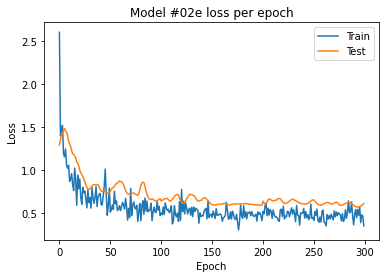

In [ ]:
M02_enhanced.plot_learning_curves()

## 3.5 Compare the results

In [ ]:
# Retrieve the performance
M02_enhanced = Model("02e")
M02_enhanced.load_model()
accuracy, precision, recall, f1, confusion = M02_enhanced.get_performance(X_test, Y_test, y_test)
print(f"accuracy is {accuracy}")
print(f"precision is {precision}")
print(f"recall is {recall}")
print(f"f1 is {f1}")
print(confusion)

Successfully loaded model Models/m02e.h5
accuracy is 0.7903225806451613
precision is 0.7874474491974649
recall is 0.7903225806451613
f1 is 0.7874337690800528
[[129  15  14   0]
 [  3 185  33   0]
 [  8  38 127   0]
 [  0   1   5   0]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# I tried both of these models for 300 iterations
# The performance is shown now:
ids = ["02", "02e"]
methods=["TL + Augmentation: Yes - Dense(128) - BN - Dropout + Dense(128)",
         "TL + Augmentation: Yes - Dense(128) - BN - Dropout + Dense(128) + Self-Supervised Learning"]

my_headers = ["Method","Accuracy","Precision","Recall", "F1 Score"]
info = []

for i, id in enumerate(ids):
    m = Model(id)
    m.load_model()
    accuracy, precision, recall, f1, confusion = m.get_performance(X_test, y_test)
    row = []
    method = methods[i]
    row.append(method)
    row.append(round(accuracy,3))
    row.append(round(precision,3))
    row.append(round(recall,3))
    row.append(round(f1,3))
    info.append(row)

print()
print("PERFORMANCE OF METHODS ON TEST SET:")
print()
print(tabulate(info, headers = my_headers))

Successfully loaded model Models/m02.h5


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Successfully loaded model Models/m02e.h5

PERFORMANCE OF METHODS ON TEST SET:

Method                                                                                        Accuracy    Precision    Recall    F1 Score
------------------------------------------------------------------------------------------  ----------  -----------  --------  ----------
TL + Augmentation: Yes - Dense(128) - BN - Dropout + Dense(128)                                  0.778        0.79      0.778       0.778
TL + Augmentation: Yes - Dense(128) - BN - Dropout + Dense(128) + Self-Supervised Learning       0.79         0.787     0.79        0.787


**Final result:**
* The self-supervised method increased on 1% on all the metrics the previous approach